## Quant Job Cleaning & Analysis

This notebook performs two functions, 1. to clean the quant finance jobs data we extracted using the serpAPI and 2. to perform analysis on this data to extract meaningful insights into salary ranges per role, and from the job descriptions, the key skills that are required. 

Steps:
1. Clean descriptions and salary ranges, including normalisation of salary data to same rates and currency (US).
2. Analysis on Jobs Data.
    - salary ranges: analysis of median, min and max salaries
    - descriptions to be used for word frequency count analysis


_Note: This analysis is not perfect, there are many improvements such as:_
1. remove duplicate job entries (maybe dual listings of same role across different recruitment agencies)
2. named roles are not common and could use standarisation based on skills and job role listed. Instead of relying on search term and result from API to categorise roles, a LLM could be trained to categorise which Quant Role this job listing is for. This removes the very likely event that the recruiting agency has 'misclassified' the quant role.

There are others, but 1 & 2 are the most pressing improvements.

In [115]:
import re
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict, Counter

# Define Base directory
base_path = Path('__file__').parent

# Path to the folder
folder = base_path / "data" / "us jobs" # change to "country" folder for non-US analysis

# output folder location
output_folder = base_path / "data" / "insights"

# Get all .csv files
csv_files = folder.glob("*.csv")

# Read and concat into one DataFrame
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# Optional: Print shape or preview
print(f"Combined DataFrame shape: {df.shape}")
df_salary = df[~df.salary.isna()]
df_salary.to_csv(output_folder / 'df_salary.csv')
df_salary.columns

Combined DataFrame shape: (4350, 22)


Index(['title', 'company_name', 'location', 'via', 'extensions', 'description',
       'job_id', 'thumbnail', 'posted_at', 'schedule_type', 'salary',
       'date_time', 'search_term', 'search_location', 'work_from_home',
       'share_link', 'job_highlights', 'apply_options', 'dental_coverage',
       'health_insurance', 'paid_time_off', 'qualifications'],
      dtype='object')

### Quick check

Look at search without job qualifications listed

In [116]:
jobs_without_qual = len(df[df['qualifications'] == 'No degree mentioned'])
jobs_count = len(df)

jobs_without_qual, jobs_without_qual / jobs_count

(16, 0.0036781609195402297)

### US Jobs Insights
All jobs 8,400 analysed that were listed for month of June 2025. 
4,350 jobs in US. 

Only 143 jobs did not mention a degree was required. 1.6% did not list degree requirements.

Unfortanetly the reality is most of these are outside US, with only 16 jobs of 4350 in US not listing a degreee. less than 0.4% of job listings. 

#### Cleaning the salary data 

The following section contains all functions and stored data related to cleaning and normalising job data salaries to a common currency and rate. 

This is especially important for non-US jobs inclusion.

In [117]:
def extract_currency_prefix(s):
    if pd.isna(s) or not isinstance(s, str):
        return None
    
    # Remove commas and normalize dashes
    s = s.replace(',', '').replace('–', '-').strip()

    # Match prefix before first number (e.g., ₹, HK$, ZAR)
    match = re.match(r'^([^\d\s]+)', s)
    if match:
        return match.group(1).strip()
    else:
        return None

In [118]:
currency_prefixes = df['salary'].apply(extract_currency_prefix)
unique_currencies = currency_prefixes.dropna().unique()

print("Unique currency prefixes:")
print(unique_currencies)

Unique currency prefixes:
['HK$']


In [119]:
currency_exchange_rates = {
    'USD': 1.00,
    '€': 1.08,       # Euro
    'SGD': 0.74,     # Singapore Dollar
    '₹': 0.012,      # Indian Rupee
    'MX$': 0.055,    # Mexican Peso
    'HK$': 0.13,     # Hong Kong Dollar
    '£': 1.27,       # British Pound
    'LKR': 0.0033,   # Sri Lankan Rupee
    'CA$': 0.73,     # Canadian Dollar
    'ZAR': 0.054,    # South African Rand
    'TRY': 0.031,    # Turkish Lira
    'A$': 0.66,      # Australian Dollar
    'MYR': 0.21,     # Malaysian Ringgit
    'CHF': 1.11,     # Swiss Franc
    'KES': 0.0077    # Kenyan Shilling
}

# Exchange rates to USD
exchange_rates = {
    'USD': 1.00,
    'EUR': 1.08,
    'SGD': 0.74,
    'INR': 0.012,
    'MXN': 0.055,
    'HKD': 0.13,
    'GBP': 1.27,
    'LKR': 0.0033,
    'CAD': 0.73,
    'ZAR': 0.054,
    'TRY': 0.031,
    'AUD': 0.66,
    'MYR': 0.21,
    'CHF': 1.11,
    'KES': 0.0077
}


prefix_to_iso = {
    '€': 'EUR',
    'SGD': 'SGD',
    '₹': 'INR',
    'MX$': 'MXN',
    'HK$': 'HKD',
    '£': 'GBP',
    'LKR': 'LKR',
    'CA$': 'CAD',
    'ZAR': 'ZAR',
    'TRY': 'TRY',
    'A$': 'AUD',
    'MYR': 'MYR',
    'CHF': 'CHF',
    'KES': 'KES'
}

In [120]:
def detect_currency(s):
    s_lower = s.lower()
    if '₹' in s or 'inr' in s_lower:
        return '₹'
    elif '€' in s or 'eur' in s_lower:
        return '€'
    elif 'sgd' in s_lower:
        return 'SGD'
    elif 'mx$' in s_lower or 'mxn' in s_lower:
        return 'MX$'
    elif 'hk$' in s_lower:
        return 'HK$'
    elif '£' in s or 'gbp' in s_lower:
        return '£'
    elif 'lkr' in s_lower:
        return 'LKR'
    elif 'ca$' in s_lower or 'cad' in s_lower:
        return 'CA$'
    elif 'zar' in s_lower:
        return 'ZAR'
    elif 'try' in s_lower:
        return 'TRY'
    elif 'a$' in s_lower or 'aud' in s_lower:
        return 'A$'
    elif 'myr' in s_lower:
        return 'MYR'
    elif 'chf' in s_lower:
        return 'CHF'
    elif 'kes' in s_lower:
        return 'KES'
    elif 'usd' in s_lower or '$' in s:  # fallback USD
        return 'USD'
    else:
        return 'USD'  # Default fallback


def clean_salary(s):
    if pd.isna(s) or not isinstance(s, str) or s.strip() == "":
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    original = s
    s = s.replace(',', '').replace('–', '-').lower()

    currency = detect_currency(original)
    fx = currency_exchange_rates.get(currency, 1.0)

    is_hourly = 'hour' in s
    is_daily = 'day' in s
    is_monthly = 'month' in s
    is_yearly = 'year' in s or not (is_hourly or is_daily or is_monthly)

    parts = re.findall(r'(\d+(?:\.\d+)?)([kKmM]?)', s)
    if not parts:
        return (np.nan, np.nan, np.nan, currency, np.nan, np.nan)

    def parse_amount(val, suffix):
        num = float(val)
        if suffix.lower() == 'k':
            num *= 1_000
        elif suffix.lower() == 'm':
            num *= 1_000_000
        return num

    try:
        numbers = [parse_amount(v, sfx) for v, sfx in parts]
    except Exception:
        return (np.nan, np.nan, np.nan, currency, np.nan, np.nan)

    if not numbers:
        return (np.nan, np.nan, np.nan, currency, np.nan, np.nan)

    min_salary_orig = min(numbers)
    max_salary_orig = max(numbers)
    avg_salary_orig = np.mean(numbers)

    # Normalize to annual
    multiplier = 1
    if is_hourly:
        multiplier = 40 * 52
    elif is_daily:
        multiplier = 336
    elif is_monthly:
        multiplier = 12

    min_salary_orig *= multiplier
    max_salary_orig *= multiplier
    avg_salary_orig *= multiplier

    # Convert to USD
    min_salary_usd = min_salary_orig * fx
    max_salary_usd = max_salary_orig * fx
    avg_salary_usd = avg_salary_orig * fx

    return (
        min_salary_usd,
        max_salary_usd,
        avg_salary_usd,
        currency,
        min_salary_orig,
        max_salary_orig
    )


In [121]:
df[['min_salary_usd', 'max_salary_usd', 'avg_salary_usd', 
    'currency', 'min_salary_orig', 'max_salary_orig']] = df['salary'].apply(
    lambda s: pd.Series(clean_salary(s))
)

In [122]:
# Sort by clean_salary in descending order
df_sorted = df.sort_values(by='avg_salary_usd', ascending=True)

# Preview
print(df_sorted[['salary', 
    'currency', 'min_salary_usd', 'max_salary_usd', 'avg_salary_usd']].head(50))

                    salary currency  min_salary_usd  max_salary_usd  \
3133            19 an hour      USD         39520.0         39520.0   
2905         10–30 an hour      USD         20800.0         62400.0   
2849         10–30 an hour      USD         20800.0         62400.0   
2793         10–30 an hour      USD         20800.0         62400.0   
2748         10–30 an hour      USD         20800.0         62400.0   
2955         10–30 an hour      USD         20800.0         62400.0   
2824         15–40 an hour      USD         31200.0         83200.0   
2932         15–40 an hour      USD         31200.0         83200.0   
2886         15–40 an hour      USD         31200.0         83200.0   
2736         15–40 an hour      USD         31200.0         83200.0   
2774         15–40 an hour      USD         31200.0         83200.0   
3343            60K a year      USD         60000.0         60000.0   
3437            60K a year      USD         60000.0         60000.0   
1455  

<Axes: >

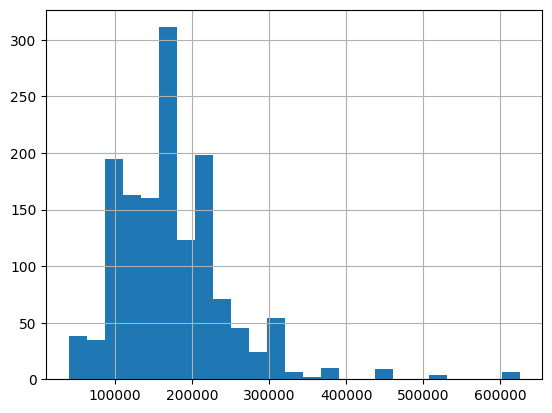

In [123]:
df[df.currency.isin(['USD'])]['avg_salary_usd'].hist(bins=25)

In [124]:
df[df.currency.isin(['USD'])].to_csv(output_folder / 'avg_salary_usd.csv')

In [125]:
search_term_to_role = {
    'Quantitative Researcher': 'Quantitative Researcher (also Quantitative Analyst)',
    'Quantitative Analyst': 'Quantitative Researcher (also Quantitative Analyst)',
    
    'Quantitative Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Algorithmic Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Energy Trader': 'Quantitative Trader (also Algorithmic Trader)',
    'Power Trader': 'Quantitative Trader (also Algorithmic Trader)',

    'Quantitative Developer': 'Quantitative Developer (also Quantitative Software Engineer)',
    'Quantitative Software Engineer': 'Quantitative Developer (also Quantitative Software Engineer)',

    'Model Validation Quantitative Analyst': 'Model Validation Quantitative Analyst',
    'Model Validation Analyst': 'Model Validation Quantitative Analyst',

    'Quantitative Risk Analyst': 'Quantitative Risk Analyst',
    'Energy Analyst': 'Quantitative Risk Analyst',

    'Quantitative Portfolio Manager': 'Quantitative Portfolio /Investment/Asset Manager',
    'Quantitative Investment Manager': 'Quantitative Portfolio /Investment/Asset Manager',
    'Quantitative Asset Manager': 'Quantitative Portfolio /Investment/Asset Manager',

    'Quantitative Strategist': 'Quantitative Strategist (Strat)',

    'Financial Engineer': 'Financial Engineer (also Quantitative Pricing Analyst or Sell-Side Quant)',
    'Quantitative Pricing Analyst': 'Financial Engineer (also Quantitative Pricing Analyst or Sell-Side Quant)'
}


In [126]:
df['role'] = df['search_term'].map(search_term_to_role)

In [127]:
percentiles = df['avg_salary_usd'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])
percentiles, df['avg_salary_usd'].mean()

(0.05     86560.3
 0.25    125500.0
 0.50    175000.0
 0.75    212500.0
 0.95    300000.0
 Name: avg_salary_usd, dtype: float64,
 np.float64(176178.56787285223))

In [128]:
percentiles = df.groupby('role')['avg_salary_usd'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
percentiles.columns = ['5th', '25th', '50th', '75th', '95th']

In [129]:
percentiles

,5th,25th,50th,75th,95th
role,,,,,
Financial Engineer (also Quantitative Pricing Analyst or Sell-Side Quant),82857.5000,125000.00,145000.0,200000.0,251500.0
Model Validation Quantitative Analyst,90000.0000,107966.75,130492.7,175000.0,300000.0
Quantitative Developer (also Quantitative Software Engineer),90000.0000,124800.00,170560.0,187500.0,268625.0
Quantitative Portfolio /Investment/Asset Manager,82500.0000,173750.00,175000.0,225000.0,361250.0
Quantitative Researcher (also Quantitative Analyst),88582.0000,141875.00,200000.0,225000.0,300000.0
Quantitative Risk Analyst,90336.4805,96000.00,103500.0,167500.0,300000.0
Quantitative Strategist (Strat),115000.0000,155000.00,175000.0,184000.0,240000.0
Quantitative Trader (also Algorithmic Trader),75000.0000,120000.00,175000.0,212500.0,300000.0


In [130]:
# Step 1: Count job postings per role
role_counts = df[~df.avg_salary_usd.isna()]['role'].value_counts()
sum(role_counts)

1455

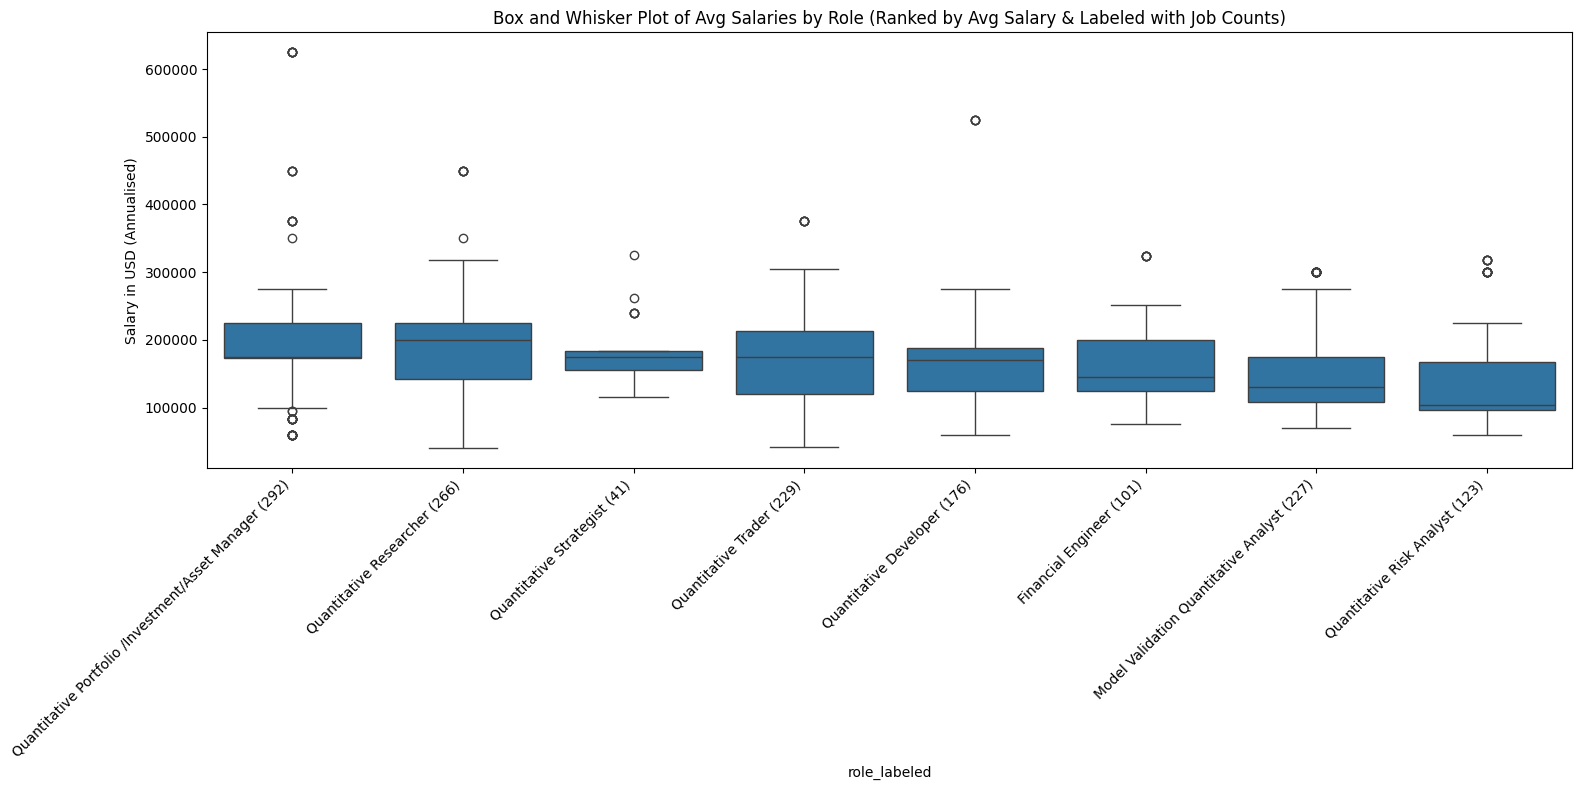

In [131]:
# Step 1: Count job postings per role
role_counts = df[~df.avg_salary_usd.isna()]['role'].value_counts()

# Step 2: Compute average salary per role
role_salary_ranking = df.groupby('role')['avg_salary_usd'].mean().sort_values(ascending=False)

cleaned_roles = [re.sub(r"\s*\(.*?\)", "", role) for role in role_salary_ranking.index]

# Step 2: Create role labels with job counts
role_labels = [f"{cleaned} ({role_counts[original]})" for cleaned, original in zip(cleaned_roles, role_salary_ranking.index)]

# Step 4: Create a mapping from original role to labeled role
role_label_map = dict(zip(role_salary_ranking.index, role_labels))
df['role_labeled'] = df['role'].map(role_label_map)

# Step 5: Set categorical order for plotting
df['role_labeled'] = pd.Categorical(df['role_labeled'], categories=role_labels, ordered=True)

# Step 6: Plot
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, x='role_labeled', y='avg_salary_usd')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Salary in USD (Annualised)")
plt.title("Box and Whisker Plot of Avg Salaries by Role (Ranked by Avg Salary & Labeled with Job Counts)")
plt.tight_layout()
plt.show()



### Saving this figure 

This next block of code saves down the box and whiskers plot of jobs as a png file.

In [132]:
# 1. Compute percentiles
percentiles = (
    df.groupby('role')['avg_salary_usd']
      .quantile([0.05, 0.25, 0.5, 0.75, 0.95])
      .unstack()
)
percentiles.columns = ['5th', '25th', '50th', '75th', '95th']

# 2. Sort by median descending
median_rank = percentiles['50th'].sort_values(ascending=False)

# 3. Count postings per role
role_counts = df[~df.avg_salary_usd.isna()]['role'].value_counts()

wrap_width = 28
role_labels = []

for i, role in enumerate(median_rank.index, start=1):
    # Remove anything in brackets from role name
    clean_name = re.sub(r"\s*\(.*?\)", "", role)
    
    count = role_counts.get(role, 0)
    median_val = median_rank.loc[role]

    # Wrap only the role name (with rank prefix)
    role_line = f"{i}. {clean_name}"
    wrapped_lines = textwrap.wrap(role_line, width=wrap_width)

    # Create the final line with count and salary
    final_line = f"({count}) – ${median_val:,.0f}"

    # Combine all lines
    full_label = "\n".join(wrapped_lines + [final_line])
    role_labels.append(full_label)

# 5. Map back onto df
label_map = dict(zip(median_rank.index, role_labels))
df['role_labeled'] = df['role'].map(label_map)

# 6. Make categorical with ordered labels
df['role_labeled'] = pd.Categorical(df['role_labeled'], categories=role_labels, ordered=True)



# 7. Plot horizontal boxplot
plt.figure(figsize=(6, 8))
ax = sns.boxplot(
    data=df,
    y='role_labeled',
    x='avg_salary_usd',
    orient='h',
    width=0.5,  # Decrease for thinner boxes, increase (up to 1.0) for thicker
    fliersize=2,  # <- Smaller dots
    flierprops=dict(marker='o', color='gray', alpha=0.5),  # Light grey, semi-transparent
    color='#0cc0df',
)

# Format x-axis as USD currency with commas and $ sign
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.xlabel("Salary in USD (Annualised)")
plt.ylabel("")  
# plt.title("Salary Distribution by Role — Ranked by Median (with Counts)")
plt.tight_layout()
# plt.show()

# Save the figure as a high-quality PNG
plt.savefig(output_folder / 'salary_box_and_whiskers_plot.png', dpi=300, bbox_inches='tight')  # dpi=300 is high-res, bbox_inches trims whitespace
plt.close()  # optional, to close the plot and free memory


### Part 2: Job Description Analysis

The following section focuses on drawing insights from the job description and pulling out insights on key skills and coding languages.

In [133]:
# Assume your dataframe is called df and descriptions are in 'description' column
texts = df['description'].dropna().str.lower()  # lowercase and drop missing

# Join all descriptions into one big string
all_text = ' '.join(texts)

# Simple tokenization: split by non-alphabetic characters
words = re.findall(r'\b[a-z]{2,}\b', all_text)  # words with length >= 2

# Count frequencies
word_freq = Counter(words)

# Convert to DataFrame for nicer display/sorting
freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

freq_df

freq_df.to_csv(output_folder / 'quantitative finance job description frequency count.csv')

In [134]:
freq_df.head(50)

,word,count
56,and,136779
27,to,70770
24,the,62325
10,of,52844
61,in,42794
50,with,32211
81,for,27711
83,or,23573
272,is,19221
89,our,16920


#### Searching for relevant terms

As you can see, this is meaningless in respect of skills that are valuable to quantitative finance professionals. 

Therefore we need to rely on a word list of quant finance core skills.

This has been constructed manually, using online resources, personal knowledge of the field and the jobs descriptions. They are hard coded in the word lists folder.

In [135]:
# Path to the folder
word_list_folder = base_path / "data" / "word lists"

# Get all .csv files
csv_files = word_list_folder.glob("*.csv")

for csv in csv_files:
    print(csv.name)

quant_finance_libraries.csv
quant_finance_core_skills.csv
quant_finance_extended_skills_list.csv
quant_finance_programming_languages.csv


#### Core Skills Anlaysis

In [136]:
# Load your description DataFrame
# Assume it's already called df and has a 'description' column
df['description'] = df['description'].fillna('').str.lower()

# Load your list of skills/phrases
skills_df = pd.read_csv(word_list_folder / 'quant_finance_core_skills.csv', header=None)
skills = skills_df[0].str.lower().str.strip().tolist()  # normalize and clean

# Initialize counter
skill_counts = defaultdict(int)

# Search each description
for desc in df['description']:
    for skill in skills:
        # Escape special regex characters in skill (in case of phrases like 'C++' or 'R&D')
        pattern = re.escape(skill)
        # Use word boundaries only if it's a single word
        if ' ' not in skill:
            pattern = r'\b' + pattern + r'\b'
        matches = re.findall(pattern, desc)
        skill_counts[skill] += len(matches)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count'])
skill_freq_df = skill_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(skill_freq_df.head(50))  # Top 20 matching skills
skill_freq_df.to_csv(output_folder / 'quant_skills.csv')

                             skill  count
0                          trading  13599
1                         research   8343
2                         analysis   6582
3                  risk management   4638
4                      programming   2978
5                      mathematics   2461
6                       statistics   2396
7                 machine learning   1925
8                          pricing   1597
9                 model validation   1534
10                    optimization   1435
11           quantitative analysis   1044
12                   data analysis    935
13                     derivatives    770
14                     credit risk    636
15            statistical analysis    581
16                  stress testing    477
17                      regression    446
18                           linux    370
19                    econometrics    314
20                     backtesting    300
21              financial modeling    288
22            strategy development

#### Core Libraries Analysis

The following analysis then looks at the frequency of the common quant finance libraries that recruiters and hiring managers are looking for such as pandas, numpy,  ect.

In [137]:
# Load your description DataFrame
# Assume it's already called df and has a 'description' column
df['description'] = df['description'].fillna('').str.lower()

# Load your list of skills/phrases
skills_df = pd.read_csv(word_list_folder / 'quant_finance_libraries.csv', header=None)
skills = skills_df[0].str.lower().str.strip().tolist()  # normalize and clean

# Initialize counter
skill_counts = defaultdict(int)

# Search each description
for desc in df['description']:
    for skill in skills:
        # Escape special regex characters in skill (in case of phrases like 'C++' or 'R&D')
        pattern = re.escape(skill)
        # Use word boundaries only if it's a single word
        if ' ' not in skill:
            pattern = r'\b' + pattern + r'\b'
        matches = re.findall(pattern, desc)
        skill_counts[skill] += len(matches)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count'])
skill_freq_df = skill_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(skill_freq_df.head(20))  # Top 20 matching skills
skill_freq_df.to_csv(output_folder / 'libraries.csv')

                      skill  count
0                    pandas    311
1                     numpy    275
2                tensorflow    152
3                   pytorch    125
4                     scipy    120
5                     spark    104
6              scikit-learn     86
7                    hadoop     72
8                   xgboost     45
9                     keras     44
10                 lightgbm     34
11               matplotlib     34
12               backtrader     18
13              statsmodels     13
14                 quantlib     10
15                  zipline      4
16                   ta-lib      4
17                     pymc      2
18  risk management toolbox      0
19                    qlnet      0


#### Coding Languages

The following analysis then looks at the frequency of the common coding languages used in quant finance. 

In [138]:
# Load your description DataFrame
# Assume it's already called df and has a 'description' column
df['description'] = df['description'].fillna('').str.lower()

# Load your list of skills/phrases
skills_df = pd.read_csv(word_list_folder / 'quant_finance_programming_languages.csv', header=None)
skills = skills_df[0].str.lower().str.strip().tolist()  # normalize and clean

# Initialize counter
skill_counts = defaultdict(int)

# Search each description
for desc in df['description']:
    for skill in skills:
        # Escape special regex characters in skill (in case of phrases like 'C++' or 'R&D')
        pattern = re.escape(skill)
        # Use word boundaries only if it's a single word
        if ' ' not in skill:
            pattern = r'\b' + pattern + r'\b'
        matches = re.findall(pattern, desc)
        skill_counts[skill] += len(matches)

# Convert to DataFrame and sort
skill_freq_df = pd.DataFrame(list(skill_counts.items()), columns=['skill', 'count'])
skill_freq_df = skill_freq_df.sort_values(by='count', ascending=False).reset_index(drop=True)

print(skill_freq_df.head(20))  # Top 20 matching skills
skill_freq_df.to_csv(output_folder / 'languages.csv')

     skill  count
0   python   3868
1      sql   1475
2        r   1287
3      sas    573
4     java    557
5   matlab    438
6    shell    315
7      vba    220
8      kdb    142
9       go    121
10    rust     27
11   scala     26
12     c++     24
13    bash     22
14   julia     16
15    perl      1
16      c#      0
